# Modeling - Univariate LSTM model

This notebook focuses on stage 2 of modeling for this project: modeling power output at one wind farm, using an LSTM trained purely on previous power output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import set_random_seed

Using TensorFlow backend.


In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import itertools as it
import time
from tqdm import tqdm_notebook
from ipywidgets import interact, Dropdown

#### Read in data

In [5]:
power_train = pd.read_csv('../datasets/power_train.csv', index_col=0)
power_train.index = pd.DatetimeIndex(power_train.index, freq='H')

power_test_int_data = pd.read_csv('../datasets/power_test_int_data.csv', index_col=0)
power_test_int_data.index = pd.DatetimeIndex(power_test_int_data.index)

power_test_int_target = pd.read_csv('../datasets/power_test_int_target.csv', index_col=0)
power_test_int_target.index = pd.DatetimeIndex(power_test_int_target.index)

wp1_predictions_sarimax = pd.read_csv('../datasets/wp1_predictions_sarimax.csv', index_col=0)
wp1_predictions_sarimax.index = pd.DatetimeIndex(wp1_predictions_sarimax.index)

# restrict analysis to one wind farm
wp1_train = power_train['wp1']
wp1_test_int_data = power_test_int_data['wp1']
wp1_test_int_target = power_test_int_target['wp1']

Previous EDA has shown that the time series is already stationary, so jump straight to modeling.

## Modeling

### Modeling functions

#### Data formatting function

In [6]:
# define function to set up data in correct format for LSTM
def format_training_data(timeseries, n_lags, len_target_seq):
    
    '''formats timeseries into LSTM input format'''
    
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel()) # flattens list of lists to one list
    
    n_shifts = n_lags + len_target_seq
    lags = pd.DataFrame({'t'+str(i): timeseries.shift(-i) for i in range(0,n_shifts)})
    lags = lags.dropna()
    
    features = lags.iloc[:,:n_lags]
    target = lags.iloc[:, n_lags:]
    
    features_arr = features.values
    features_arr = np.reshape(features_arr, (features_arr.shape[0], features_arr.shape[1], 1))
    target_arr = target.values
    
    return features_arr, target_arr

#### Model prediction functions

In [7]:
def forecast_next_48hrs(model, data):
    
    '''forecasts next 48 hours of power output available data'''
    
    output_size = model.get_config()[1]['config']['units']
    for _ in range(48//output_size):
        batch_size, num_lags, num_features = model.get_config()[0]['config']['batch_input_shape']
        lag_data = np.reshape(data[-num_lags:].values, (batch_size, num_lags, num_features))
        pred = model.predict(lag_data, batch_size=batch_size)[0]
        data = data.append(pd.Series(pred, index = [data.index[-1]+pd.Timedelta(hours=i+1) for i in range(output_size)]))
        
    return data[-48:]

In [8]:
def make_forecasts(model, data_series):
        
    '''forecasts many sets of 48 hours of power output given repeated 36 hour windows of available data'''
    
    predictions = pd.Series()
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    
    for pattern_num in range(num_patterns):
        data = data_series[36*pattern_num:36*(pattern_num+1)]
        forecast = forecast_next_48hrs(model, data)
        predictions = predictions.append(forecast)
    
    return predictions

#### Complete model build and testing function

In [9]:
def build_model(training_data, n_lags, n_outputs, n_nodes, stateful = False, epochs=1, verbose=0):
    
    # format data
    features, target = format_training_data(training_data, n_lags = n_lags, len_target_seq = n_outputs)
    
    # set up model
    batch_size = 1
    model = Sequential()
    model.add(LSTM(n_nodes,
                  batch_input_shape = (batch_size, features.shape[1], features.shape[2]),
                  stateful = stateful))
    model.add(Dense(n_outputs)) # output layer, no activation function for regression problem
    
    if verbose == 1:
        model.summary()
    
    # compile and fit model
    model.compile(loss='mean_squared_error', optimizer='adam')
    if stateful:
        for i in range(epochs): # loop over epochs manually so can clear carry channel after each epoch
            history = model.fit(features, target, validation_data = None,
                 epochs = 1, batch_size = batch_size, verbose=verbose, shuffle=False)
            model.reset_states()
    else:
        history = model.fit(features, target, validation_data = None,
             epochs = epochs, batch_size = batch_size, verbose=verbose, shuffle=False)
        
    return model, history

### Analysis of models

#### Understanding how n_lags, n_outputs and stateful parameters affect output

In [10]:
settings_dict= {'n_lags': [2,36],
                'n_outputs': [1,48],
                'stateful': [True, False]}

settings_combs = list(it.product(*settings_dict.values()))

settings = pd.DataFrame(settings_combs, columns=settings_dict.keys())

In [11]:
# WARNING - this cell takes a long time to run (about an hour on my laptop) - it is running 8 LSTMS!

RMSE = []
run_time = []

for idx in tqdm_notebook(settings.index, desc='Progress', leave=True):
    
    np.random.seed(42)
    
    t0 = time.time()
    
    model, history = build_model(wp1_train,
                               n_lags = settings.loc[idx,'n_lags'],
                               n_outputs = settings.loc[idx,'n_outputs'], 
                               n_nodes = 2, 
                               stateful = settings.loc[idx,'stateful'], 
                               epochs = 3, 
                               verbose=0)
    t1 = time.time()
    
    model_predictions = make_forecasts(model, wp1_test_int_data)
    model_RMSE = mean_squared_error(y_true = wp1_test_int_target, y_pred = model_predictions)**0.5
    
    RMSE.append(model_RMSE)
    run_time.append(t1-t0)
                
model_perf = pd.concat([settings, pd.DataFrame(RMSE, columns=['RMSE'])], axis=1)
model_perf = pd.concat([model_perf, pd.DataFrame(run_time, columns=['run_time'])], axis=1)

HBox(children=(IntProgress(value=0, description='Progress', max=8), HTML(value='')))

In [12]:
setting_select = Dropdown(
options = list(model_perf.columns[0:3]),
value = model_perf.columns[0],
description = 'Compare:',
)

def plot_widget(setting = model_perf.columns[0]):
    
    sns.lmplot(x='RMSE',y='run_time', data = model_perf, hue = setting, fit_reg=False, 
               size=5, aspect=2,  scatter_kws={"s": 500}, palette = 'Set1');
    
    sort_cols = list(model_perf.columns[0:3])
    sort_cols.remove(setting)
    
    model_perf.sort_values(by=sort_cols, inplace=True)
    for n in range(model_perf.shape[0]//2):
        row_pair = model_perf.iloc[n*2:n*2+2,-2:].values
        plt.plot(row_pair[:,0], row_pair[:,1], '--', color='k')
    
    ax = plt.gca()    
    
    ax.set_xlim(0.2,0.5)
    ax.set_ylim(0, 1000)
    
    ax.set_xlabel('RMSE', fontsize=14)
    ax.set_ylabel('run time', fontsize=14)
    ax.set_title('How model performance varies with {} setting\n'.format(setting), fontsize=18);
    
        
interact(plot_widget, setting = setting_select);

interactive(children=(Dropdown(description='Compare:', options=('n_lags', 'n_outputs', 'stateful'), value='n_lags'), Output()), _dom_classes=('widget-interact',))

The widget above plots the performance of 8 different LSTM models in terms of RMSE and run-time. The 8 LSTM models have been built using permutations of the following settings:

- **n_lags**: 2, 36
- **n_outputs**: 1, 48
- **stateful**: True, False

where:
- n_lags is the number of input timesteps used in each predictive step of the model. 
- n_outputs is the number of output predictions made in one go. Where this is 1, a single prediction is made at a time, and this is fed back in as an input timestep to predict the next step iteratively until 48 predictions have been made. 
- Stateful is a setting used by keras for the LSTM model layer, and represents whether or not cell states are propagated to the next batch in the sequence.

The widget is used by selecting a setting for comparison. The graph will then display one variation of the setting in red and the other in blue, with a black dotted line drawn between pairs of models where the unselected settings are the same for both items in the pair. This allows a comparison of models on a setting by setting basis.

The graph shows that:

- Models that use the full 36 hrs of available data as an input take a lot longer to run and don't perform much better than those that only use 2 hrs of data.
- Outputting a full 48 hr forecast in one step creates more accurate forecasts than predicting one hour at a time and looping through the forecasting.
- Models that are not stateful seem to perform very slightly better than those that are, but there is not a consistent trend.

#### Understanding how number of nodes affects output

In [13]:
RMSE_by_node_dict = {}

for n in tqdm_notebook(range(1,11), desc='Progress', leave=True):
    
    np.random.seed(42)
    
    model, history = build_model(wp1_train, n_lags = 2, n_outputs = 48, n_nodes = n, stateful = False, epochs = 3, verbose=0)
    
    model_predictions = make_forecasts(model, wp1_test_int_data)
    model_RMSE = mean_squared_error(y_true = wp1_test_int_target, y_pred = model_predictions)**0.5
    
    RMSE_by_node_dict[n] = model_RMSE
    
RMSE_by_node = pd.DataFrame(list(RMSE_by_node_dict.items()), columns=['num_nodes','RMSE'])
RMSE_by_node.set_index('num_nodes', inplace=True)

HBox(children=(IntProgress(value=0, description='Progress', max=10), HTML(value='')))

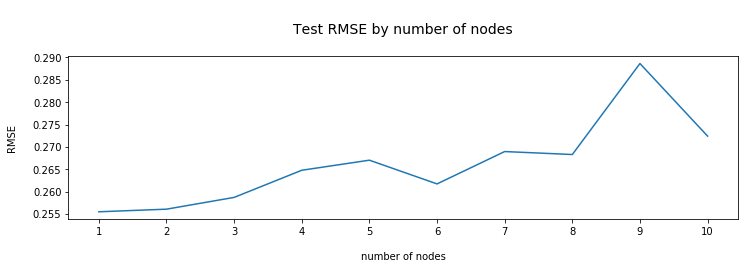

In [14]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(RMSE_by_node.index,RMSE_by_node.values, )
ax.set_ylabel('RMSE\n', fontsize=10)
ax.set_xlabel('\nnumber of nodes', fontsize=10)
ax.set_xticks(RMSE_by_node.index)
ax.set_title('\nTest RMSE by number of nodes\n', fontsize=14);

In [15]:
min_pos = np.argmin(RMSE_by_node.values)
print('Optimal number of nodes: '+str(RMSE_by_node.index[min_pos]))
print('RMSE: '+str(RMSE_by_node.values[min_pos]))

Optimal number of nodes: 1
RMSE: [0.25547478]


Increasing the number of nodes seems to decrease the accuracy of the model

#### Understanding how the number of epochs affects output

In [16]:
# use inner components of build and test function to benefit from testing between training epochs

In [17]:
training_data = wp1_train
test_data = wp1_test_int_data
target_data = wp1_test_int_target
n_lags = 2
n_outputs = 48
n_nodes = 1

np.random.seed(42)
set_random_seed(42)

# format data
features, target = format_training_data(training_data, n_lags = n_lags, len_target_seq = n_outputs)
    
# set up model
batch_size = 1
model = Sequential()
model.add(LSTM(n_nodes,
              batch_input_shape = (batch_size, features.shape[1], features.shape[2]),
              stateful = False))
model.add(Dense(n_outputs)) # output layer, no activation function for regression problem
    
# compile and fit model
model.compile(loss='mean_squared_error', optimizer='adam')
    
RMSE_by_epoch_dict = {}

for n in tqdm_notebook(range(1,11), desc='Progress', leave=True):
    
    model.fit(features, target, validation_data = None,
             epochs = 1, batch_size = batch_size, verbose=0, shuffle=False)
        
    # test model
    LSTM_predictions = make_forecasts(model, test_data)
    LSTM_RMSE = mean_squared_error(y_true = target_data, y_pred = LSTM_predictions)**0.5

    RMSE_by_epoch_dict[n] = LSTM_RMSE
    
RMSE_by_epoch = pd.DataFrame(list(RMSE_by_epoch_dict.items()), columns=['num_epochs','RMSE'])
RMSE_by_epoch.set_index('num_epochs', inplace=True)

HBox(children=(IntProgress(value=0, description='Progress', max=10), HTML(value='')))

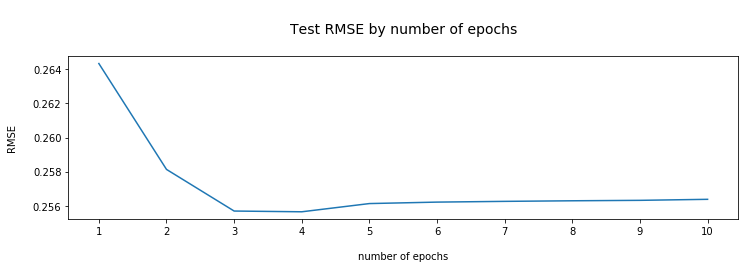

In [18]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(RMSE_by_epoch.index,RMSE_by_epoch.values, )
ax.set_ylabel('RMSE\n', fontsize=10)
ax.set_xlabel('\nnumber of epochs', fontsize=10)
ax.set_xticks(RMSE_by_epoch.index)
ax.set_title('\nTest RMSE by number of epochs\n', fontsize=14);

In [19]:
min_pos = np.argmin(RMSE_by_epoch.values)
print('Optimal number of epochs: '+str(RMSE_by_epoch.index[min_pos]))
print('RMSE: '+str(RMSE_by_epoch.values[min_pos]))

Optimal number of epochs: 4
RMSE: [0.25566732]


#### Analyse best model

In [24]:
np.random.seed(42)
set_random_seed(42)

# best settings
n_lags = 2
n_outputs = 48
n_nodes = 1
stateful = False
epochs = 3

model, history = build_model(wp1_train, n_lags, n_outputs, n_nodes, stateful, epochs, verbose=1);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (1, 1)                    12        
_________________________________________________________________
dense_21 (Dense)             (1, 48)                   96        
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
10404/10404 [==============================] - 38s 4ms/step - loss: 0.0457
Epoch 2/3
10404/10404 [==============================] - 36s 3ms/step - loss: 0.0453
Epoch 3/3
10404/10404 [==============================] - 36s 3ms/step - loss: 0.0452


In [25]:
# as the model predicts 48 hours of forecasts in one step, it is valid to compare train and test scores
model_predictions = make_forecasts(model, wp1_test_int_data)
model_RMSE = mean_squared_error(y_true = wp1_test_int_target, y_pred = model_predictions)**0.5
print('Train RMSE: ', history.history['loss'][-1]**0.5)
print('Test RMSE: ', model_RMSE)

Train RMSE:  0.21267549768144112
Test RMSE:  0.2557107306064416


Train RMSE:  0.21267552299866777
Test RMSE:  0.2557108474055062

In [ ]:
# doesn't show significant overfitting
# improvement of ~19% on baseline

#### Forecast plot

In [26]:
def make_widget(model, data_series, target_series = None, alternative_prediction = None):
    
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    windows = [str(i)+':  '+ str(data_series.index[36*i])+' - '+str(data_series.index[36*(i+1)-1]) for i in range(num_patterns)]
   
    style = {'description_width': 'initial'}
    
    window_select = Dropdown(
    options=windows,
    value=windows[0],
    description='Data window:',
    style = style,
    layout={'width': '400px'}
    )

    def plot_widget(data_window = windows[0]):
    
        # filter dataframe
        data_window_int = int(data_window.split(':')[0])
        data = data_series[36*data_window_int:36*(data_window_int+1)]
        forecast = forecast_next_48hrs(model, data)
    
        # plot
        fig, ax = plt.subplots(figsize=(20,6))
        
        data.plot(label='observed data', c='k')
        forecast.plot(label='forecast', ax=ax, c='C0')
                
        if alternative_prediction is not None:
            alt_forecast = alternative_prediction[48*data_window_int:48*(data_window_int+1)]
            alt_forecast['forecast'].plot(label='alt forecast', ax=ax, c='C0', style='--')
        
        if target_series is not None:
            target = target_series[48*data_window_int:48*(data_window_int+1)]
            target.plot(label='target data', ax=ax, c='grey')
            
        ax.minorticks_off()
        idx = pd.date_range(data.index[0]-pd.Timedelta(hours=1), forecast.index[-1], freq='H')
        ax.set_xlim(idx[0],idx[-1])
        ax.set_ylim(0,1)

        ax.set_xticks(idx[::12])
        ax.set_xticklabels(idx[::12].strftime('%Y-%m-%d\n%H:%M:%S'))
        
        plt.title('Observed and forecast power output\n', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Power output\n', fontsize=14)

        plt.legend()
        plt.show()
    
    interact(plot_widget, data_window=window_select);

In [27]:
make_widget(model = model, data_series = power_test_int_data['wp1'], 
            target_series = power_test_int_target['wp1'],
            alternative_prediction = wp1_predictions_sarimax)

interactive(children=(Dropdown(description='Data window:', layout=Layout(width='400px'), options=('0:  2010-09-09 13:00:00 - 2010-09-11 00:00:00', '1:  2010-09-13 01:00:00 - 2010-09-14 12:00:00', '2:  2010-09-16 13:00:00 - 2010-09-18 00:00:00', '3:  2010-09-20 01:00:00 - 2010-09-21 12:00:00', '4:  2010-09-23 13:00:00 - 2010-09-25 00:00:00', '5:  2010-09-27 01:00:00 - 2010-09-28 12:00:00', '6:  2010-09-30 13:00:00 - 2010-10-02 00:00:00', '7:  2010-10-04 01:00:00 - 2010-10-05 12:00:00', '8:  2010-10-07 13:00:00 - 2010-10-09 00:00:00', '9:  2010-10-11 01:00:00 - 2010-10-12 12:00:00', '10:  2010-10-14 13:00:00 - 2010-10-16 00:00:00', '11:  2010-10-18 01:00:00 - 2010-10-19 12:00:00', '12:  2010-10-21 13:00:00 - 2010-10-23 00:00:00', '13:  2010-10-25 01:00:00 - 2010-10-26 12:00:00', '14:  2010-10-28 13:00:00 - 2010-10-30 00:00:00', '15:  2010-11-01 01:00:00 - 2010-11-02 12:00:00', '16:  2010-11-04 13:00:00 - 2010-11-06 00:00:00', '17:  2010-11-08 01:00:00 - 2010-11-09 12:00:00', '18:  2010-11-11 13:00:00 - 2010-11-13 00:00:00', '19:  2010-11-15 01:00:00 - 2010-11-16 12:00:00', '20:  2010-11-18 13:00:00 - 2010-11-20 00:00:00', '21:  2010-11-22 01:00:00 - 2010-11-23 12:00:00', '22:  2010-11-25 13:00:00 - 2010-11-27 00:00:00', '23:  2010-11-29 01:00:00 - 2010-11-30 12:00:00', '24:  2010-12-02 13:00:00 - 2010-12-04 00:00:00', '25:  2010-12-06 01:00:00 - 2010-12-07 12:00:00', '26:  2010-12-09 13:00:00 - 2010-12-11 00:00:00', '27:  2010-12-13 01:00:00 - 2010-12-14 12:00:00', '28:  2010-12-16 13:00:00 - 2010-12-18 00:00:00', '29:  2010-12-20 01:00:00 - 2010-12-21 12:00:00', '30:  2010-12-23 13:00:00 - 2010-12-25 00:00:00', '31:  2010-12-27 01:00:00 - 2010-12-28 12:00:00'), style=DescriptionStyle(description_width='initial'), value='0:  2010-09-09 13:00:00 - 2010-09-11 00:00:00'), Output()), _dom_classes=('widget-interact',))